In [1]:
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 2.2 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 6.2 MB/s eta 0:00:00


In [2]:
import urllib
import json

import numpy as np
import pandas as pd

from shapely.geometry import shape

import folium
from folium.plugins import Draw

from IPython.display import JSON

## 1) Input definition

In [3]:
start_date = '2024-08-14'
end_date = '2025-02-14'

### Define an area (or point) of interest by drawing in the map

In [4]:
m = folium.Map(zoom_start=2, location=(0, 0))
draw = Draw(export=True)
draw.add_to(m)
m

Click on the created area of interest and copy the dictionary in the second line of the window that appear and then paste it in the variable `geom` as input to `shape`

In [5]:
geom = shape(
    {"type":"Polygon","coordinates":[[[11.175842,46.452997],[11.175842,46.549417],[11.340637,46.549417],[11.340637,46.452997],[11.175842,46.452997]]]}
)

### Alternatively upload your area of interest

## 2) Retrieve the bursts info with https request

In [6]:
https_request = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Bursts?$filter=" + urllib.parse.quote(
    f"ContentDate/Start ge {start_date}T00:00:00.000Z and ContentDate/Start le {end_date}T23:59:59.000Z and "
    f"PolarisationChannels eq 'VV' and "
    f"OData.CSC.Intersects(area=geography'SRID=4326;{geom.wkt}')"
) + "&$top=1000"

with urllib.request.urlopen(https_request) as response:
    content = response.read().decode()
bursts = json.loads(content)
JSON(bursts)

<IPython.core.display.JSON object>

In [7]:
bursts_uniqueTrack = {}
burstId_list = []
track_list = []
for b in bursts['value']:
    if b['RelativeOrbitNumber'] not in track_list:
        bursts_uniqueTrack[b['RelativeOrbitNumber']] = {}
        track_list.append(b['RelativeOrbitNumber'])
    if b['BurstId'] not in burstId_list:
        bursts_uniqueTrack[b['RelativeOrbitNumber']][b['BurstId']] = b['GeoFootprint']['coordinates']
        burstId_list.append(b['BurstId'])

## 3) Show on map

In [8]:
# Initialize the map and center it in the middle of the bursts

lat, lon = [], []
for burst in bursts_uniqueTrack.values():
    for coords in burst.values():
        lat = lat + [c[1] for c in coords[0]]
        lon = lon + [c[0] for c in coords[0]]
        
m = folium.Map(
    location=[np.mean([max(lat), min(lat)]), np.mean([max(lon), min(lon)])],
    zoom_start=8
)


# Add the area of interest

if geom.geom_type == 'Point':
    folium.Marker([geom.y, geom.x]).add_to(m)

if geom.geom_type == 'Polygon':
    folium.Polygon(
        locations=[(y, x) for x, y in geom.exterior.coords],
        color='blue',
        fill=True,            
        fill_color='blue',    
        fill_opacity=0.4
    ).add_to(m)


# Add each burst grouped by track

for track, burst in bursts_uniqueTrack.items():
    
    polygon_group = folium.FeatureGroup(name=f'Track {track}')

    for burstId, polygon in bursts_uniqueTrack[track].items():

        # Create and add the first polygon to its feature group
        pol = folium.Polygon(
            locations=np.flip(np.squeeze(polygon), axis=1),
            color='red'
        )
        pol.add_to(polygon_group)
    
    polygon_group.add_to(m)


# Show the map

folium.LayerControl().add_to(m)
m

## Plot calendar

In [9]:
import calendar
import matplotlib.pyplot as plt

def display_calendar(year, month, highlighted_dates={}):

    cal = calendar.monthcalendar(year, month)
    fig, ax = plt.subplots(figsize=(4, 2))
    ax.set_xticks([])
    ax.set_yticks([])
                
    for row, week in enumerate(cal):
        for col, day in enumerate(week):
            if day == 0:
                continue
            color = highlighted_dates.get(day, "white")
            ax.add_patch(plt.Rectangle((col - 0.5, row - 0.5), 1, 1, color=color, alpha=0.6))
            ax.text(col, row, str(day), ha="center", va="center", fontsize=12, weight='bold')

    ax.set_xlim(-0.5, 6.5)
    ax.set_ylim(len(cal) - 0.5, -0.5)
    ax.set_title(calendar.month_name[month] + f" {year}")
    plt.show()

In [10]:
date, track = [], [] 
for b in bursts['value']:
    date.append(b['BeginningDateTime'])
    track.append(b['RelativeOrbitNumber'])
df = pd.DataFrame(data={'date': date, 'track': track})
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop_duplicates(subset=['track', 'year', 'month', 'day'])
df = df.sort_values(by='date', ascending=True)

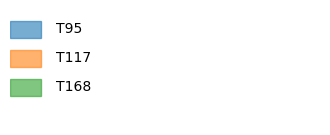

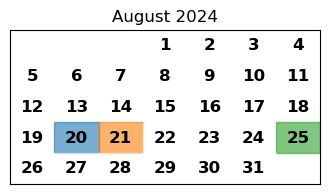

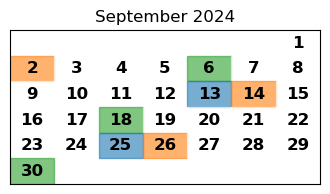

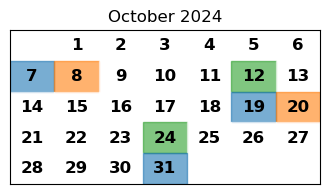

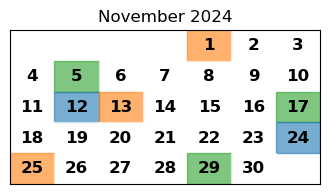

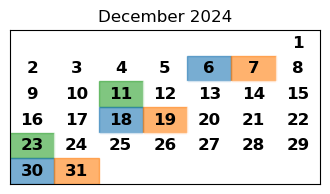

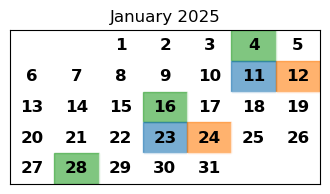

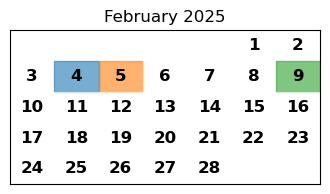

In [11]:
color_track = {}
fig, ax = plt.subplots(figsize=(4, len(df['track'].unique())*0.5))
for i, t in enumerate(df['track'].unique()):
    color_track[t] = f'C{i}'
    ax.add_patch(plt.Rectangle((0, -i*0.5), 0.1, 0.3, color=color_track[t], alpha=0.6))
    ax.text(0.15, -i*0.5+0.1, f'T{t}', fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(-len(df['track'].unique())*0.5, 0.5)
ax.axis('off')
plt.show()

for year in df['year'].unique():
    df_year = df.loc[df['year'] == year, :]
    for month in df_year['month'].unique():
        h = {}
        for i, row in df_year.loc[df_year['month'] == month, :].iterrows():
            h[row['day']] = color_track[row['track']]
        display_calendar(year, month, h)